In [1]:
import json
import os
from sympy import symbols, simplify, sin, expand
#from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [2]:
import sissopp
from sissopp.py_interface import get_fs_solver

In [5]:
x = np.linspace(-2, 2, 500)
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
noise = rng.normal(size=x.shape)
y = np.cos(x) + noise 

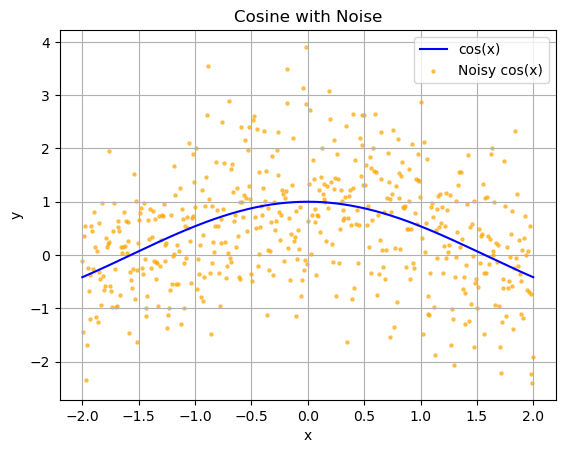

In [6]:
plt.plot(x, np.cos(x), label='cos(x)', color='blue')
plt.scatter(x, y, s=5, alpha=0.6, label='Noisy cos(x)', color='orange')
plt.legend()
plt.title('Cosine with Noise')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [ ]:
# Save to CSV in a format SISSO++ expects
df = pd.DataFrame({"sample_id": [f"s{i+1}" for i in range(len(x))], 'f1': x, 'target': y})
df.to_csv("/home/paolo/Thesis/Test_SISSO/data/cosine_data.csv", index=False)
data_file = "/home/paolo/Thesis/Test_SISSO/data/cosine_data.csv"

os.environ["SISSOPP_TUT_DAT_FILE"] = data_file

In [ ]:
# Try the fit with the exact functional form
cos_json = {
    'data_file': data_file,
     'property_key': 'target',
     'desc_dim': 1,
     'n_sis_select': 10,
     'max_rung': 2,
     'calc_type': 'regression',
     'min_abs_feat_val': 1e-05,
     'max_abs_feat_val': 1e8,
     'n_residual': 10,
     'n_models_store': 2,
     'leave_out_frac': 0.0,
     'leave_out_inds': [],
     'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
}
json.dump(cos_json, open("/home/paolo/Thesis/Test_uncertainty/data/cos.json", "w"), indent=4)

In [ ]:
# # Try the fit with the exact functional form
# cos_json = {
#     'data_file': data_file,
#      'property_key': 'target',
#      'desc_dim': 1,
#      'n_sis_select': 10,
#      'max_rung': 2,
#      'calc_type': 'regression',
#      'min_abs_feat_val': 1e-05,
#      'max_abs_feat_val': 1e8,
#      'n_residual': 10,
#      'n_models_store': 2,
#      'leave_out_frac': 0.0,
#      'leave_out_inds': [],
#      'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
# }
# json.dump(cos_json, open("/home/paolo/Thesis/Test_uncertainty/data/cos.json", "w"), indent=4)

In [16]:
formulas = []
a0_list = []
c0_list = []
for i in range(10):
    filename = f'./models_cosine/train_dim_1_model_{i}.dat'
    with open(filename, 'r') as f:
        line1 = next(f)               # First line
        for _ in range(4): next(f)    # Skip lines 2 to 5
        line6 = next(f)               # Sixth line
        formula = line1.replace('#', '').strip()
        # Split line6 by spaces
        parts = line6.strip().split()
        a0_i = parts[3].rstrip(',')
        c0_i = parts[4].rstrip(',')

        formulas.append(formula)
        a0_list.append(a0_i)
        c0_list.append(c0_i)
        print(formula, a0_i, c0_i)

c0 + a0 * cos(f1) 1.026516626042362e+00 -2.513565483497359e-02
c0 + a0 * (sin(f1) / f1) 2.722430765680743e+00 -1.743636004010924e+00
c0 + a0 * (sin(f1) * f1) -7.192705739146151e-01 1.067479753468510e+00
c0 + a0 * (cos(f1) - (f1^2)) 2.777296467752327e-01 6.857838707456738e-01
c0 + a0 * (f1^2) -3.797943293052196e-01 9.482006102788901e-01
c0 + a0 * (cos(f1) + (f1^2)) -5.976215092714716e-01 1.510466509322255e+00
c0 + a0 * cos((f1^2)) 5.750589227309285e-01 3.081072596264779e-01
c0 + a0 * (sin(f1)^2) -1.167218004837731e+00 1.134346477826760e+00
c0 + a0 * ((f1^2)^2) -9.712679781678096e-02 7.530790459783490e-01
c0 + a0 * (sin(f1) - (f1^2)) 2.763907975739480e-01 8.097766439532607e-01


In [17]:
a0 = np.array(a0_list, dtype=float)
c0 = np.array(c0_list, dtype=float)
a0, c0

(array([ 1.02651663,  2.72243077, -0.71927057,  0.27772965, -0.37979433,
        -0.59762151,  0.57505892, -1.167218  , -0.0971268 ,  0.2763908 ]),
 array([-0.02513565, -1.743636  ,  1.06747975,  0.68578387,  0.94820061,
         1.51046651,  0.30810726,  1.13434648,  0.75307905,  0.80977664]))

In [18]:
x_simb = sp.symbols('f1')
symbol_map = {'x': x_simb}

# Converts the equtions (stored into the 'Feature Expression' column of df) from strings into sympy objects
sympy_exprs = [sp.sympify(f, locals=symbol_map) for f in formulas]
# Builds Python functions starting from the sympy expressions
functions = [sp.lambdify((x_simb), expr, modules='numpy') for expr in sympy_exprs]

In [19]:
sympy_exprs

[a0*cos(f1) + c0,
 a0*sin(f1)/f1 + c0,
 a0*f1*sin(f1) + c0,
 a0*(-f1**2 + cos(f1)) + c0,
 a0*f1**2 + c0,
 a0*(f1**2 + cos(f1)) + c0,
 a0*cos(f1**2) + c0,
 a0*sin(f1)**2 + c0,
 a0*f1**4 + c0,
 a0*(-f1**2 + sin(f1)) + c0]

In [21]:
Phi = np.column_stack([f(x) for f in functions])
n_features = Phi.shape[1]
n_features

10

In [ ]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    # Normal weights
    alpha = pm.Normal("c0", mu=c0[0], sigma=10)
    beta = pm.Normal("a0", mu=a0, sigma=10)
    # Sigma is positively define and normally distributed --> HalfNormal
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome, Linear model
    mu = alpha + beta * Phi[0]

    # Likelihood (sampling distribution) of observations --> normal distribution with the deterministic equation as mean and sigma as variance
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)